In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cpu')

In [6]:
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)
        
    
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1))
        x = self.pool2(F.relu(self.conv2))
        # 把x展开
        x = x.view(-1,36*6*6)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        
        return x

In [7]:
net = CNNnet()

In [8]:
net = net.to(device)

卷积操作也是需要激活函数保证非线性的，所以在卷积运算之后，需要用到激活函数(结果+偏移)


常用的激活函数有nn.Sigmoid，nn.ReLU，nn.LeakyReLU，nn.Tanh

### 卷积函数

`torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride=1,padding=0,dilation=1,groups=1,bias=True,padding_mode='zeros')`

- groups：控制输入和输出之间的连接，group=1，输出是所有输入的卷积；group=2，相当于有两个并排的两个卷积层，每个卷积层计算输入通道的一般，并且产生的输出也是输入通道的一半，随后将输出连接，这应该是一种加速手段
- bias：给输出添加偏移


`torch.nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=1,padding=0,output_padding=0,groups=1,bias=True,dilation=1,padding_mode='zero')`

全局池化的优势：各个类别和Feature map之间的联系更加直观，FM被转化为分类概率也更加容易，并且GAP中没有参数需要学习，所以目前CNN的最后几个fc层大多用GAP替换

Pytorch中使用`AdaptiveMaxPool2d(1)`或者`AdaptiveAvgPool2d(1)`实现

### CIFAR-10分类

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data',train=True,download=False,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=4,shuffle=True,num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=4,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [16]:
def show_image(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

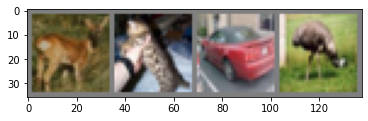

 deer   cat   car  bird


In [17]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 定义网络

In [32]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)
        
    
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # 把x展开
        x = x.view(-1,36*6*6)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        
        return x

In [33]:
net = CNNNet()
net = net.to(device)

In [34]:
net

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### 初始化参数

In [35]:
for m in net.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight)
        nn.init.xavier_normal_(m.weight)
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias,0)
    elif isinstance(m,nn.Linear):
        nn.init.normal_(m.weight)

#### 训练模型

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [37]:
for epoch in range(10):
    running_loss = 0.0
    for i,data in enumerate(train_loader, 0):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch+1},{i+1} loss: {running_loss / 2000}]')
            running_loss = 0.0
print('finish')

[1,2000 loss: 208.06907073450088]
[1,4000 loss: 2.3025851249694824]
[1,6000 loss: 2.3025851249694824]
[1,8000 loss: 2.3025851249694824]
[1,10000 loss: 2.3025851249694824]
[1,12000 loss: 2.3025851249694824]
[2,2000 loss: 2.3025851249694824]
[2,4000 loss: 2.3025851249694824]
[2,6000 loss: 2.3025851249694824]


KeyboardInterrupt: 